In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from sklearn.metrics import jaccard_score 
# Import functions from scipy
# pdist is pariwise distance 
# squareform: Convert a vector-form distance vector 
# to a square-form distance matrix, and vice-versa.
from scipy.spatial.distance import pdist, squareform

This notebook is from the DataCamp course "Building Recommendation Engines in Python." 
https://learn.datacamp.com

In [2]:
# load the User Ratings dataset
# this is a subset of the MovieLens dataset 
user_ratings_df = pd.read_csv('user_ratings.csv')
print(user_ratings_df.head())

   userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


## Non-personalized Recommendations 

One approach is to recommend the most popular movie which in this case is the movie that has been viewed by the most users. This is ***implicit data.*** 

In [3]:
# Get the counts of occurrences of each movie title
movie_popularity = user_ratings_df["title"].value_counts()

# Inspect the most common values
print(movie_popularity.head().index)

Index(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)'],
      dtype='object')


Forrest Gump has been watched by 329 viewers and is the most viewed movie. 

## User Ratings  
A lot of users might watch a movie and really dislike it. The **ratings** in this dataset give us a source of **explicit data**. 

In [4]:
# Find the mean of the ratings given to each title
average_rating_df = user_ratings_df[["title", "rating"]].groupby('title').mean()

# Order the entries by highest average rating to lowest
sorted_average_ratings = average_rating_df.sort_values(by='rating', ascending=False)

# Inspect the top movies
print(sorted_average_ratings.head())

                                     rating
title                                      
Gena the Crocodile (1969)               5.0
True Stories (1986)                     5.0
Cosmic Scrat-tastrophe (2015)           5.0
Love and Pigeons (1985)                 5.0
Red Sorghum (Hong gao liang) (1987)     5.0


Even though this is a real world dataset, the highest-ranked movies are pretty obscure. Let's check how many users have actually seen these movies. 

## Combining Popularity and Reviews 
Two of the most common methods of non-personalized recommendations are: 
+ Most frequently watched
+ Most highly rated 
We've seen some of the downsides of both methods. Recommending the most frequently watched doesn't take into account how people felt about the movie. Recommending the most highly rated, we might recommend really long-tail, niche items. Here we recommend highly rated movies but make sure that they have been reviewed by at least 50 users. 

In [5]:
# Create a list of only movies appearing > 50 times in the dataset
movie_popularity = user_ratings_df["title"].value_counts()
popular_movies = movie_popularity[movie_popularity > 50].index
print(popular_movies)

Index(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Jurassic Park (1993)', 'Braveheart (1995)',
       'Terminator 2: Judgment Day (1991)', 'Schindler's List (1993)',
       ...
       'Grumpier Old Men (1995)', 'Magnolia (1999)', 'Mystic River (2003)',
       'Army of Darkness (1993)', 'Blow (2001)', 'Training Day (2001)',
       'Mulholland Drive (2001)', 'The Devil's Advocate (1997)',
       'Splash (1984)', 'Bad Boys (1995)'],
      dtype='object', length=437)


In [6]:
# Use this popular_movies list to filter the original DataFrame
popular_movies_rankings =  user_ratings_df[user_ratings_df["title"].isin(popular_movies)]

In [7]:
# Find the average rating given to these frequently watched films
popular_movies_average_rankings = popular_movies_rankings[["title", "rating"]].groupby('title').mean()
print(popular_movies_average_rankings.sort_values(by="rating", ascending=False).head())

                                                      rating
title                                                       
Shawshank Redemption, The (1994)                    4.429022
Godfather, The (1972)                               4.289062
Fight Club (1999)                                   4.272936
Cool Hand Luke (1967)                               4.271930
Dr. Strangelove or: How I Learned to Stop Worry...  4.268041


Now we have an easy way to make non-personalized recommendations based on the rating of an item and how frequently it has been interacted with. 

## Identifying Commonly Seen Together Items 

In [8]:
# Create the function to find all permutations
def find_movie_pairs(x):
    """
    takes in list of movies a user has viewed 
    returns dataframe with pairs of movies watched by the same user
    """
    pairs = pd.DataFrame(list(permutations(x.values, 2)),
                       columns=['movie_a', 'movie_b'])
    return pairs

In [9]:
# Apply the function to the title column and reset the index
movie_combinations = user_ratings_df.groupby('userId')['title'].apply(
                     find_movie_pairs).reset_index(drop=True)

print(movie_combinations)

                   movie_a                           movie_b
0         Toy Story (1995)           Grumpier Old Men (1995)
1         Toy Story (1995)                       Heat (1995)
2         Toy Story (1995)       Seven (a.k.a. Se7en) (1995)
3         Toy Story (1995)        Usual Suspects, The (1995)
4         Toy Story (1995)        From Dusk Till Dawn (1996)
...                    ...                               ...
60793295         31 (2016)                 Gen-X Cops (1999)
60793296         31 (2016)                  Bloodmoon (1997)
60793297         31 (2016)  Sympathy for the Underdog (1971)
60793298         31 (2016)                     Hazard (2005)
60793299         31 (2016)                Blair Witch (2016)

[60793300 rows x 2 columns]


## Counting Up the Pairs 
Now we have a DataFrame of pairs of movies watched by the same user. This has limited use without knowing which movies are most commonly paired. 

In [10]:
# Calculate how often each item in movie_a occurs with the items in movie_b
# this results in a nested series 
combination_counts = movie_combinations.groupby(['movie_a', 'movie_b']).size()

In [11]:
# Convert the results to a DataFrame and reset the index
# reset index for ease of reading 
combination_counts_df = combination_counts.to_frame(name= 'size').reset_index()
print(combination_counts_df.head())

      movie_a                                     movie_b  size
0  '71 (2014)                 (500) Days of Summer (2009)     1
1  '71 (2014)                  10 Cloverfield Lane (2016)     1
2  '71 (2014)                            127 Hours (2010)     1
3  '71 (2014)  13 Assassins (Jûsan-nin no shikaku) (2010)     1
4  '71 (2014)                             13 Hours (2016)     1


Now we have an aggregated DataFrame we can use to make recommendations. 

## Make Movie Recommendations 

In [12]:
# Sort the counts from highest to lowest
combination_counts_df.sort_values('size', ascending=False, inplace=True)
combination_counts_df.head()

,movie_a,movie_b,size
20672049,"Shawshank Redemption, The (1994)",Forrest Gump (1994),231
8538313,Forrest Gump (1994),"Shawshank Redemption, The (1994)",231
8537603,Forrest Gump (1994),Pulp Fiction (1994),230
18567035,Pulp Fiction (1994),Forrest Gump (1994),230
20675275,"Shawshank Redemption, The (1994)",Pulp Fiction (1994),222


In [13]:
# Find the movies most frequently watched by people who watched Thor
thor_df = combination_counts_df[combination_counts_df['movie_a'] == 'Thor (2011)']
thor_df.head()

,movie_a,movie_b,size
23575218,Thor (2011),Iron Man (2008),34
23573693,Thor (2011),"Dark Knight, The (2008)",31
23578243,Thor (2011),Up (2009),30
23572747,Thor (2011),Avatar (2009),30
23575139,Thor (2011),Inception (2010),30


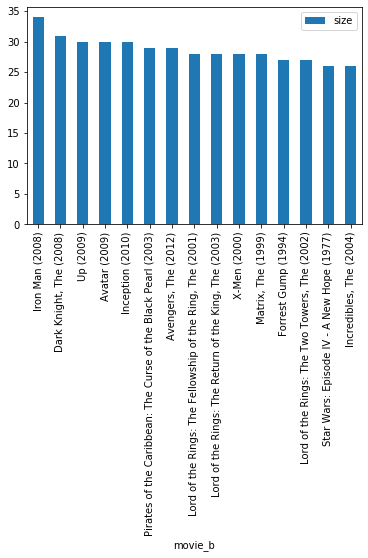

In [14]:
# Plot the results
thor_df.iloc[0:15].plot.bar(x="movie_b")
plt.show()

Iron Man was the most commonly watched movie by users who watched Thor. This means it would be a good movie to recommend to Thor watchers as it shows that they have similar fans. 

## Content-Based 
Recommend items that are similar to items users have liked in the past. <br>
Example item-attributes: 
+ Length
+ Language
+ Genre 
+ Author 
+ Year Published 
A big advantage of using item attributes instead of feedback for recommendations is that you can make recommendations for new items that don't have reviews or purchases yet. 

In [15]:
# load the User Ratings dataset
# this is a subset of the MovieLens dataset 
movie_genres_df = pd.read_csv('movies.csv')
print(movie_genres_df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [16]:
print(len(movie_genres_df))

9742


There are 9742 movies in this dataset. 

## Vectorize Attributes 
Note that right now we have a **one to many** relationship. For every one movie, there are many genres. 

In [17]:
# used this Stack Overflow post for the approach:
# https://stackoverflow.com/questions/48010030/create-multiple-new-columns-based-on-pipe-delimited-column-in-pandas/48010102?noredirect=1#comment82995598_48010102
movie_genres_df = movie_genres_df.join(movie_genres_df.genres.str.get_dummies())
movie_genres_df.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Select only the rows with values in the name column equal to Toy Story
toy_story_genres = movie_genres_df.loc[movie_genres_df['title'] == 'Toy Story (1995)']

# Inspect the subset
print(toy_story_genres)

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   

   ...  Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  \
0  ...          0       0     0        0        0        0       0         0   

   War  Western  
0    0        0  

[1 rows x 23 columns]


The newly formatted table with a vector contained in a row per movie and a column per feature will allow us to calculate distances and similarities between movies. 

In [21]:
# Select only the rows with values in the name column equal to Toy Story
yogi_bear_genres = movie_genres_df.loc[movie_genres_df['title'] == 'Yogi Bear (2010)']

# Inspect the subset
print(yogi_bear_genres)

      movieId             title           genres  (no genres listed)  Action  \
7501    83177  Yogi Bear (2010)  Children|Comedy                   0       0   

      Adventure  Animation  Children  Comedy  Crime  ...  Film-Noir  Horror  \
7501          0          0         1       1      0  ...          0       0   

      IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
7501     0        0        0        0       0         0    0        0  

[1 rows x 23 columns]


Both Yogi Bear and Toy Story are in the 'Children' and 'Comedy' genres. One way to make recommendations is to choose movies that are more similar because they have more genres in common. 

## Calculating Similarity Between Movies 

**Jaccard Similarity** is the number of attributes that two items have in common divided by the total number of their combined attributes. 

In [37]:
# Extract just the rows containing GoldenEye and Toy Story
goldeneye_values = movie_genres_df.loc[movie_genres_df['title'] == 'GoldenEye (1995)', 'Action':'Western'].values[0]
print(goldeneye_values)

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


In [38]:
toy_story_values = movie_genres_df.loc[movie_genres_df['title'] == 'Toy Story (1995)', 'Action':'Western'].values[0]
print(toy_story_values)

[0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [39]:
# Find the similarity between GoldenEye and Toy Story
print(jaccard_score(goldeneye_values, toy_story_values))

0.14285714285714285


The higher the Jaccard Score, the more similar the two movies are. The similarity score between GoldenEye and Toy Story is low because a spy movie and animated kids' movie aren't that similar. 

In [40]:
skyfall_values = movie_genres_df.loc[movie_genres_df['title'] == 'Skyfall (2012)', 'Action':'Western'].values[0]
print(skyfall_values)

[1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]


In [41]:
# Find the similarity between GoldenEye and Skyfall
print(jaccard_score(goldeneye_values, skyfall_values))

0.75


The similarity score for two spy films is much higher. 

Previously, I've seen recommendations that a similarity metric like **Cosine Similarity** would be useful for a sparse movie matrix. This blog post gives a brief description of the differences between Jacard Similarity and Cosine Similarity: https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50

## Comparing Similarity Between All Movies in Dataset 

In [49]:
# Calculate all pairwise distances
#jaccard_distances = pdist(movie_cross_table.values, metric='jaccard')
# df.loc[:, 'C':'E']
movie_cross_table = movie_genres_df.loc[:, 'Action':'Western']
movie_cross_table.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
movie_cross_table.values

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [54]:
jaccard_distances = pdist(movie_cross_table.values, metric='jaccard')
print(jaccard_distances)

[0.4        0.83333333 0.85714286 ... 1.         1.         1.        ]


In [56]:
# Convert the distances to a square matrix
jaccard_similarity_array = 1 - squareform(jaccard_distances)
print(jaccard_similarity_array)

[[1.         0.6        0.16666667 ... 0.         0.16666667 0.2       ]
 [0.6        1.         0.         ... 0.         0.         0.        ]
 [0.16666667 0.         1.         ... 0.         0.         0.5       ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.16666667 0.         0.         ... 0.         1.         0.        ]
 [0.2        0.         0.5        ... 0.         0.         1.        ]]


## Similarity Matrix 

In [59]:
# Wrap the array in a pandas DataFrame
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, 
                                     index=movie_genres_df['title'], 
                                     columns=movie_genres_df['title'])
jaccard_similarity_df.head()

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.6,0.166667,0.142857,0.200000,0.0,0.166667,0.400000,0.0,0.142857,...,0.285714,0.166667,0.166667,0.2,0.0,0.500000,0.600000,0.000000,0.166667,0.200000
Jumanji (1995),0.600000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.200000,...,0.000000,0.000000,0.000000,0.0,0.0,0.166667,0.200000,0.000000,0.000000,0.000000
Grumpier Old Men (1995),0.166667,0.0,1.000000,0.666667,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.200000,0.000000,0.333333,0.0,0.0,0.200000,0.250000,0.000000,0.000000,0.500000
Waiting to Exhale (1995),0.142857,0.0,0.666667,1.000000,0.333333,0.0,0.666667,0.000000,0.0,0.000000,...,0.166667,0.250000,0.666667,0.0,0.0,0.166667,0.200000,0.333333,0.000000,0.333333
Father of the Bride Part II (1995),0.200000,0.0,0.500000,0.333333,1.000000,0.0,0.500000,0.000000,0.0,0.000000,...,0.250000,0.000000,0.500000,0.0,0.0,0.250000,0.333333,0.000000,0.000000,1.000000


The table has movies as rows and columns for quick lookups of the distance between any movie pairing. 